In [1]:
# Sobre el dataset de 'California housing' realiza un modelo de regresión de Red Elástica de la mediana de los valores de las casas (Y-respuesta) con
# las variables restantes (numéricas y categóricas) del dataset.
# a) Fijando r=0.1
# b) Fijando r=0.95
# En ambos casos ajusta alpha por validación cruzada usando k=10 particiones.

In [4]:
# Apartado a)
# Se empieza repitiendo el proceso seguido en el ejercicio 6.2. (cargar dataset, imputación, estandarización, variables indicadoras...)
import pandas as pd
from sklearn.impute import SimpleImputer # Para imputación
from sklearn.preprocessing import StandardScaler # Para estandarización
from sklearn.pipeline import Pipeline # Para combinar imputación y estandarización
from sklearn.preprocessing import OneHotEncoder # Para crear variable indicadora
from sklearn.compose import ColumnTransformer # Para considerar la variable categórica en la imputación y estandarización

housing = pd.read_csv('datasets/housing/housing.csv')

# Variable respuesta
respuesta = housing['median_house_value'].copy()
housing = housing.drop('median_house_value', axis=1)

# Variables numéricas
housing_num = housing.drop('ocean_proximity', axis=1)

# Imputación y estandarización de las variables numéricas
num_pipeline = Pipeline([
    ('imputador', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num) # Se aplica pipeline

# Nombre de variables numéricas
num_attribs = list(housing_num)

# Nombre de variable categórica
cat_attribs = ['ocean_proximity']

# Se añade la variable categórica al proceso de imputación y estandarización. Se añade una de las variables categóricas en el intercepto 
# (drop='first')
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(drop='first'), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing) # Se aplica pipeline

In [7]:
# Ahora ya se puede llevar a cabo la regresión de Red Elástica. Para ello se usa la clase ElasticNetCV del módulo 'sklearn'.
from sklearn.linear_model import ElasticNetCV
import numpy as np

np.random.seed(3)
e_net = ElasticNetCV(cv=10, l1_ratio=0.1) # 'cv' es el número de particiones para la validación cruzada y 'l1_ratio' es el hiperparámetro 'r'
e_net.fit(housing_prepared, respuesta)

print('Coeficientes del modelo de regresión de Red Elástica:')
print('Intercepto:', e_net.intercept_)
print('Beta:', e_net.coef_)

Coeficientes del modelo de regresión de Red Elástica:
Intercepto: 206865.4749645959
Beta: [ -7.3285382  -23.12318484  16.94967114  21.48093501   7.83412633
  -3.90892666  10.4757704  110.83304095 -36.29600822   0.
   8.01288948   7.55581778]


In [10]:
# La penalización es bastante fuerte y por eso los coeficientes de beta son mucho menores, en valor absoluto, que aquellos que se obtienen con el 
# modelo sin penalización. Sin embargo, como r=0.1, la penalización es principalmente de tipo Ridge y por ello apenas se realiza selección de
# variables (solo un coeficiente se hace cero).

In [12]:
# Apartado b)
# Repetimos el procedimiento con r=0.95.

np.random.seed(3)
e_net_b = ElasticNetCV(cv=10, l1_ratio=0.95) # 'cv' es el número de particiones para la validación cruzada y 'l1_ratio' es el hiperparámetro 'r'
e_net_b.fit(housing_prepared, respuesta)

print('Coeficientes del modelo de regresión de Red Elástica:')
print('Intercepto:', e_net_b.intercept_)
print('Beta:', e_net_b.coef_)

Coeficientes del modelo de regresión de Red Elástica:
Intercepto: 208267.51670197048
Beta: [-1469.95946607 -3059.90966939  2747.34800787  2439.66788593
   801.03210661 -1171.1003709   1151.60483666 15113.62768328
 -5336.05497542     0.          1215.79217006  1141.77891116]


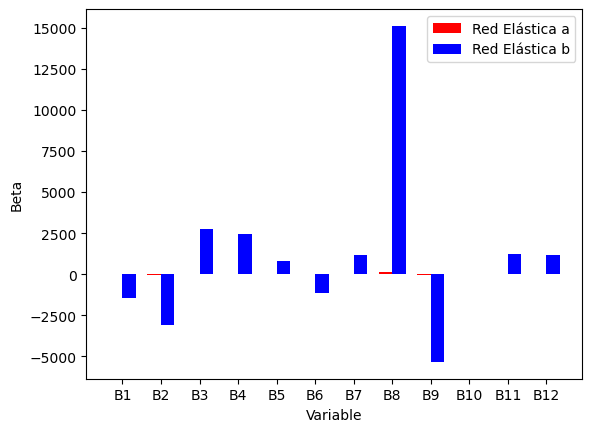

In [17]:
# Comparamos los resultados obtenidos con cada modelo de regresión elástica mediante un diagrama de barras. Se importa la librería pyplot.
import matplotlib.pyplot as plt

ancho = 0.35
r1 = np.arange(len(e_net.coef_)) # Posición de las barras para los resultados de 'Red Elástica a'
r2 = [x+ancho for x in r1] # Posición de las barras para los resultados de 'Red Elástica b'
plt.bar(r1, e_net.coef_, color='red', width=ancho, label='Red Elástica a')
plt.bar(r2, e_net_b.coef_, color='blue', width=ancho, label='Red Elástica b')
plt.xticks([x+ancho*0.5 for x in range(len(e_net.coef_))],
          ['B'+str(i) for i in range(1,13)])
plt.legend()
plt.xlabel('Variable')
plt.ylabel('Beta')
plt.show()

In [34]:
# Del gráfico anterior se observa que para el apartado a, en el que predomina la regresión Ridge, los coeficientes se han encogido demasiado.

# Se puede hacer otra comparación de las dos Redes Elásticas a partir del error de test con cada una. Para ello se crea un tercer objeto 'e_net_c', al
# que se le pasa como argumento de l1_ratio una lista con las los valores de 'r'.

e_net_c = ElasticNetCV(cv=10, l1_ratio=[0.1, 0.95])
e_net_c.fit(housing_prepared, respuesta)
print(e_net_c.l1_ratio_)

0.95


In [27]:
# Se escoge el valor de r=0.95 porque es con el que se minimiza el error de test por CV